## Identifying recyclables - single label

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.plots import *

In [16]:
PATH = 'data'

In [17]:
ls {PATH}

test/  train/


In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

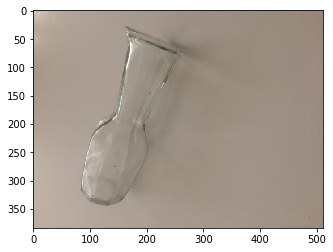

In [19]:
files = os.listdir(f'{PATH}/test/glass')[:5]
img = plt.imread(f'{PATH}/test/glass/{files[0]}')
plt.imshow(img);

In [20]:
img.shape

(384, 512, 3)

In [68]:
arch=resnet34
sz=224
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

 88%|████████▊ | 28/32 [00:01<00:00, 19.92it/s, loss=13.9]


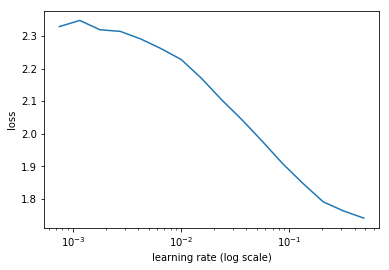

In [69]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot()

In [70]:
learn.precompute=False
learn.fit(0.1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.031127   0.516623   0.84375   
    1      0.836866   0.510709   0.804688                  



[0.51070935, 0.8046875]

In [71]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')

In [72]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.692632   0.471587   0.835938  
    1      0.538666   0.393521   0.867188                    
    2      0.413787   0.352213   0.886719                    
    3      0.34836    0.343127   0.898438                    
    4      0.271563   0.338891   0.90625                     
    5      0.210364   0.336218   0.898438                    
    6      0.176944   0.325385   0.898438                    



[0.3253852, 0.8984375]

In [73]:
# Evaluate with test time augmentation 
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.91015625

[[38  0  0  2  0  1]
 [ 0 45  5  0  1  0]
 [ 1  1 38  0  0  1]
 [ 0  0  1 59  0  0]
 [ 0  3  1  0 45  0]
 [ 0  0  3  2  1  8]]


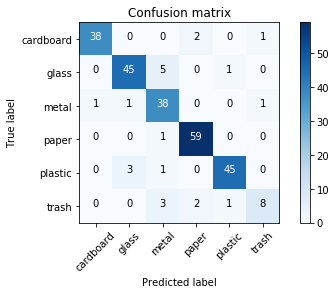

In [74]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [75]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [76]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+'/' + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


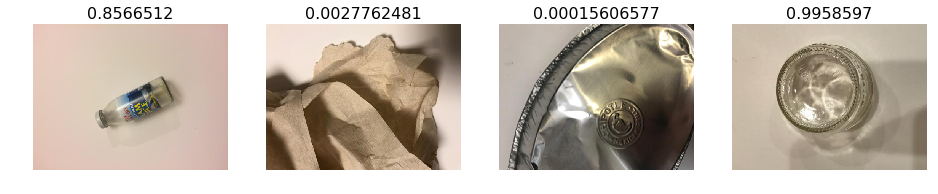

In [77]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


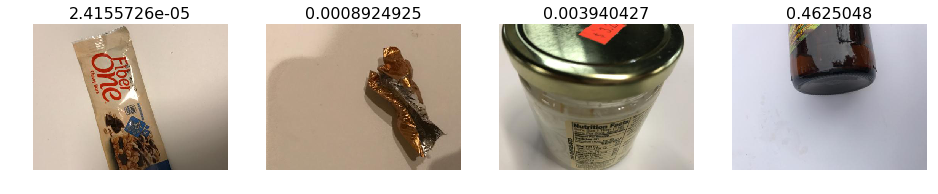

In [78]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [79]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cardboard
Most correct glass
Most correct metal
Most correct paper
Most correct metals
Most correct trash


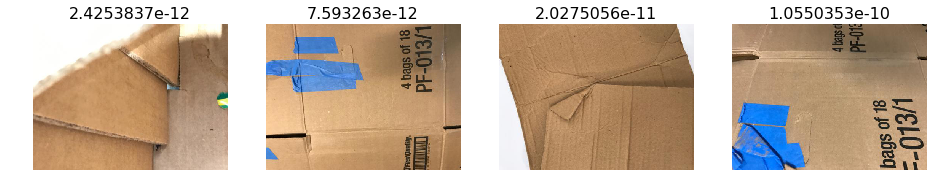

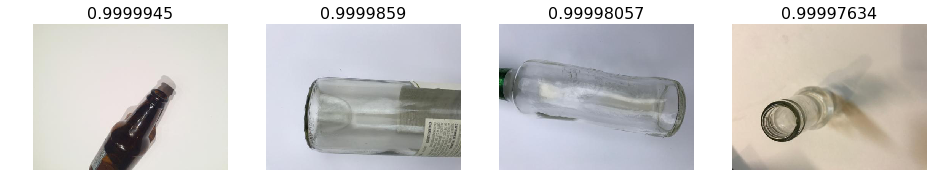

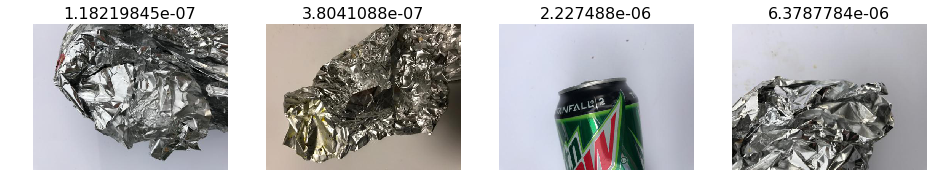

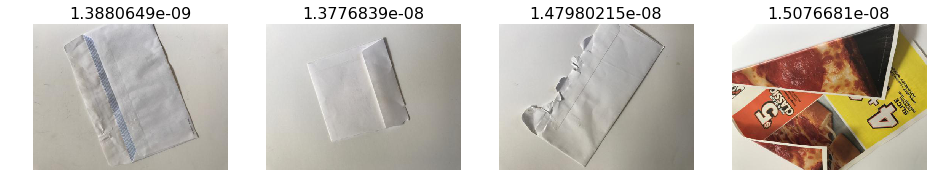

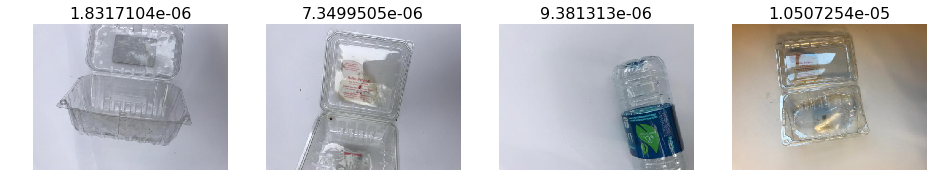

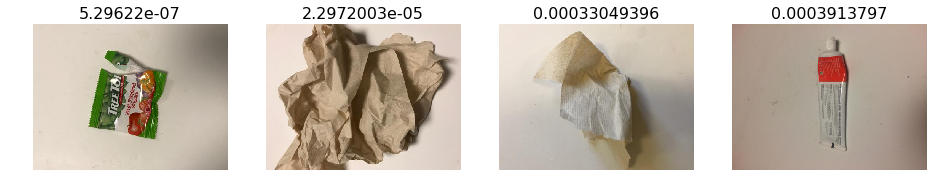

In [80]:
plot_val_with_title(most_by_correct(0, True), "Most correct cardboard")
plot_val_with_title(most_by_correct(1, True), "Most correct glass")
plot_val_with_title(most_by_correct(2, True), "Most correct metal")
plot_val_with_title(most_by_correct(3, True), "Most correct paper")
plot_val_with_title(most_by_correct(4, True), "Most correct metals")
plot_val_with_title(most_by_correct(5, True), "Most correct trash")


Most incorrect cardboard
Most incorrect glass
Most incorrect metal
Most incorrect paper
Most incorrect metals
Most incorrect trash


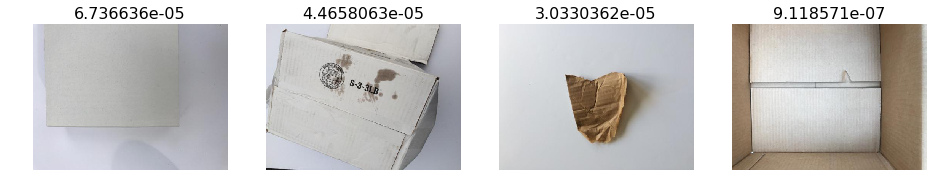

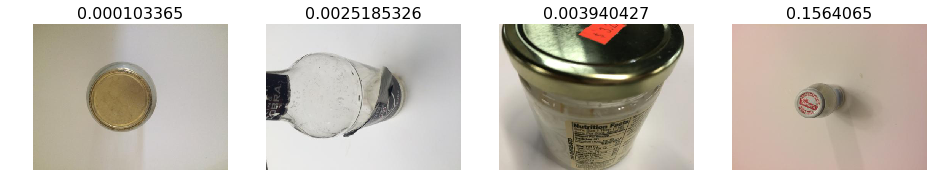

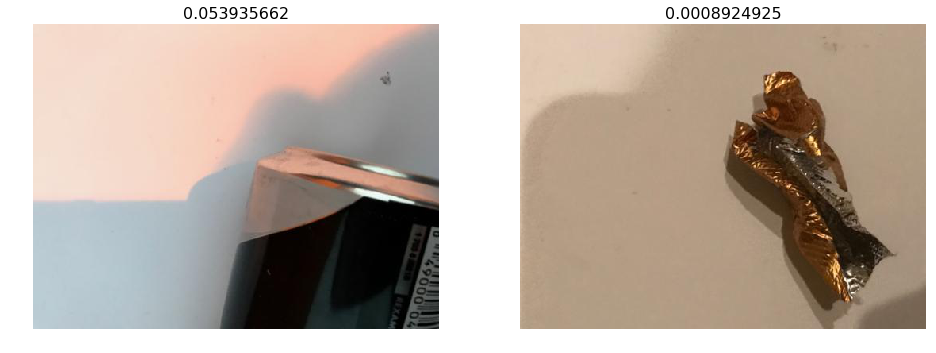

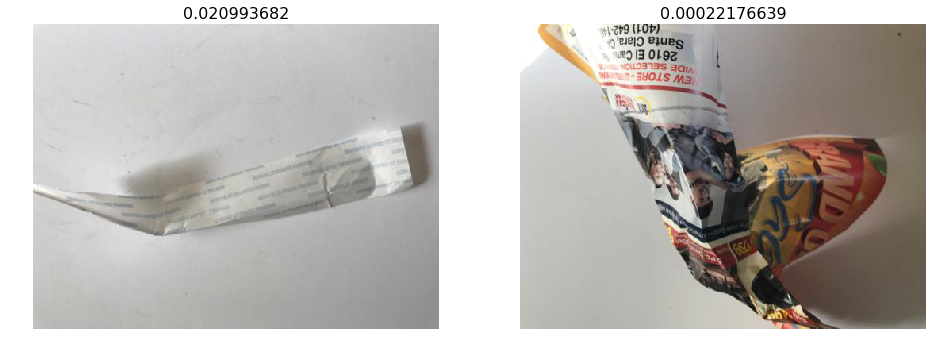

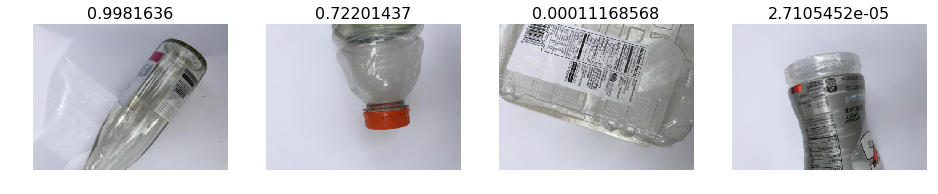

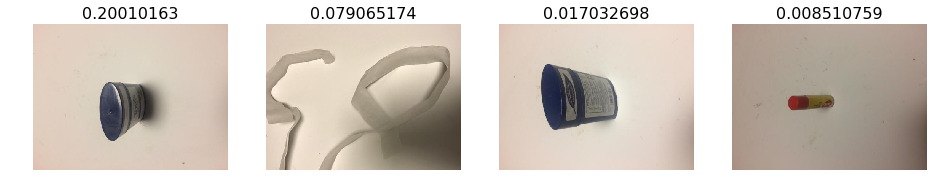

In [81]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cardboard")
plot_val_with_title(most_by_correct(1, False), "Most incorrect glass")
plot_val_with_title(most_by_correct(2, False), "Most incorrect metal")
plot_val_with_title(most_by_correct(3, False), "Most incorrect paper")
plot_val_with_title(most_by_correct(4, False), "Most incorrect metals")
plot_val_with_title(most_by_correct(5, False), "Most incorrect trash")

Most uncertain predictions


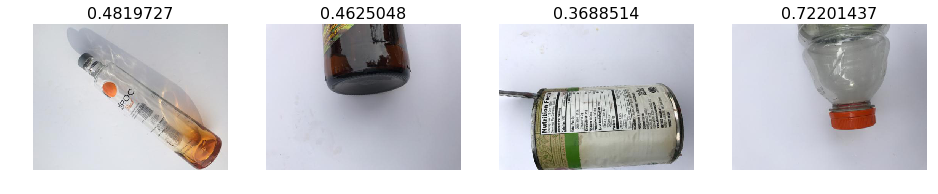

In [82]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")